## AuxTel AzEl offsets - 28-Apr-21

In this notebook, investigate az-el offsets from 11-Mar-21\
This is going to analyze a pair of exposures

In [2]:
import sys, time, os, asyncio, glob

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle as pkl
import pandas as pd
import astropy.io.fits as pf
from astropy.time import Time, TimeDelta
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from lsst.daf.butler import Butler as gen3Butler
from lsst.daf.persistence import Butler as gen2Butler
from lsst_efd_client import EfdClient
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

In [3]:
# Get EFD client
client = EfdClient('summit_efd')

# This is Lupton's code for unpacking the 100/second data
def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

# This makes the plots more readable
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

# Set up charImage task
charConfig = CharacterizeImageConfig()
charConfig.doMeasurePsf = False#True
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = True   
charConfig.detection.minPixels = 500
charTask = CharacterizeImageTask(config=charConfig)

In [4]:
# Gen3 butler
dayObs = 20210311
REPO_DIR = '/repo/main'
butler = gen3Butler(REPO_DIR, collections="LATISS/raw/all")

In [22]:
expId1 = 2021031100418
expId2 = 2021031100419
mData1 = butler.get('raw.metadata', detector=0, exposure=expId1)
exp1Start = Time(mData1['DATE-BEG'],scale='tai')
exp1End = Time(mData1['DATE-END'],scale='tai')
mData2 = butler.get('raw.metadata', detector=0, exposure=expId2)
exp2Start = Time(mData2['DATE-BEG'],scale='tai')
exp2End = Time(mData2['DATE-END'],scale='tai')

/home/cslage/alternate_branches/obs_base/python/lsst/obs/base/filters.py:92: FutureWarning: Call to deprecated function (or staticmethod) resetFilters. (Removed with no replacement (FilterLabels do not need to be reset). Will be removed after v22.) -- Deprecated since version v22.
  lsst.afw.image.utils.resetFilters()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.5.0/Linux64/afw/21.0.0-28-g795c15604+e3fba76c04/python/lsst/afw/image/utils.py:58: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  Filter.reset()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.5.0/Linux64/afw/21.0.0-28-g795c15604+e3fba76c04/python/lsst/afw/image/utils.py:59: FutureWarning: Removed with no replacement (but see lsst.afw.image.TransmissionCurve).Will be removed after v22.
  FilterProperty.reset()
/home/cslage/alternate_branches/obs_base/python/lsst/obs/base/filters.py:189: FutureWarning: Call to deprecated function (or staticmethod) defineFilter. (Removed with no replacement 

In [23]:
# These are for finding the timestamps of the offset event
offsets = await client.select_time_series("lsst.sal.ATPtg.command_offsetAzEl", ['*'],
                                          exp1Start, exp2End)

In [24]:
# Get the programmed offsets.
print(f"Number of offset commands = {len(offsets)}.  It should be just one.")
for i, offset in enumerate(offsets.values):
    print(i, Time(offsets.index[i]).tai.isot,offset[0], offset[1])
offsetTime = Time(offsets.index[0],scale='tai')
commandedAzShift = offsets.values[0][0]
commandedElShift = offsets.values[0][1]

Number of offset commands = 1.  It should be just one.
0 2021-03-12T04:37:24.334 -105 -105


In [25]:
# Now get the mount data
mount_position = await client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", ['*'],
                                          exp1Start, exp2End)
az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1)
el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1)
print(len(el))

2000


In [26]:
# Calculate the tracking shift

az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]

shiftIndex = np.where(times>offsetTime.tai.unix)[0][0]
valsPerSecond = 100
n1 = np.where(times>exp1Start.tai.unix)[0][0] # Start of fist exposure
n2 = np.where(times>exp1End.tai.unix)[0][0] # End of first exposure
n3 = np.where(times>exp2Start.tai.unix)[0][0] # Start of second exposure
try:
    n4 = np.where(times>exp2End.tai.unix)[0][0] # End of second exposure
except:
    n4 = len(times)
            
# Fit the tracking before the offset with a quadratic
az_vals_fit = az_vals[n1:n2]
el_vals_fit = el_vals[n1:n2]
times_fit = times[n1:n2]

az_fit = np.polyfit(times_fit, az_vals_fit, 2)
el_fit = np.polyfit(times_fit, el_vals_fit, 2)

az_model = az_fit[0] * times * times + az_fit[1] * times + az_fit[2]
el_model = el_fit[0] * times * times + el_fit[1] * times + el_fit[2]

# Apply this model and calculate the departure from the model after the shift
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

az_shift = np.mean(az_error[n3:n4])
el_shift = np.mean(el_error[n3:n4])


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'Time (Unix - seconds)')

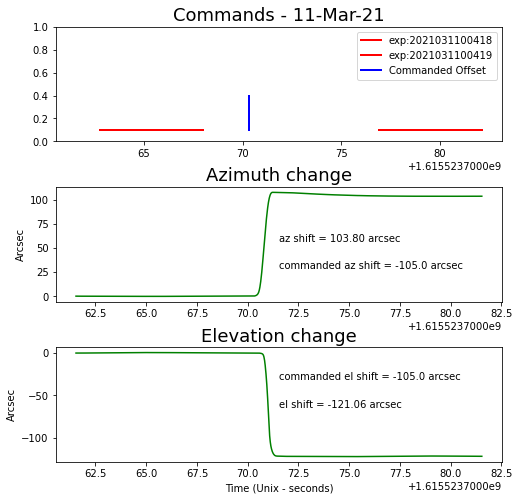

In [27]:
# Now plot the shift
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.4)
plt.subplot(3,1,1)
plt.title(f"Commands - 11-Mar-21", fontsize = 18)
plt.plot(times, times*0.0-1.0, color='green')
plt.plot([exp1Start.tai.unix, exp1End.tai.unix], [0.1,0.1], color='red', lw=2.0, label=f"exp:{expId1}")
plt.plot([exp2Start.tai.unix, exp2End.tai.unix], [0.1,0.1], color='red', lw=2.0, label=f"exp:{expId2}")
plt.plot([offsetTime.tai.unix,offsetTime.tai.unix], [0.1, 0.4], color='blue', lw=2.0, label="Commanded Offset")
plt.ylim(0.0, 1.0)
plt.legend()
plt.subplot(3,1,2)
plt.title(f"Azimuth change", fontsize = 18)
plt.plot(times, az_error, color='green')
plt.text(np.mean(times), np.mean(az_error), f"az shift = {az_shift:.2f} arcsec")
plt.text(np.mean(times), np.mean(az_error)*0.5, f"commanded az shift = {commandedAzShift:.1f} arcsec")
plt.ylabel("Arcsec")
plt.subplot(3,1,3)
plt.title(f"Elevation change", fontsize = 18)
plt.plot(times, el_error, color='green')
plt.text(np.mean(times), np.mean(el_error), f"el shift = {el_shift:.2f} arcsec")
plt.text(np.mean(times), np.mean(el_error)*0.5, f"commanded el shift = {commandedElShift:.1f} arcsec")
plt.ylabel("Arcsec")
plt.xlabel("Time (Unix - seconds)")


In [15]:
# Get the raw quickLook data.  Only Gen2 works for now
REPO_DIR = '/project/shared/auxTel/rerun/quickLook'
gen2_butler = gen2Butler(REPO_DIR)
dayObs = '2021-03-11'

<ipython-input-15-97549a3fb31d>:3: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  gen2_butler = gen2Butler(REPO_DIR)
<ipython-input-15-97549a3fb31d>:3: FutureWarning: Gen2 Butler has been deprecated (LatissMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  gen2_butler = gen2Butler(REPO_DIR)
/home/cslage/alternate_branches/obs_base/python/lsst/obs/base/filters.py:92: FutureWarning: Call to deprecated function (or staticmethod) resetFilters. (Removed with no replacement (FilterLabels do not need to be reset). Will be removed after v22.) -- Deprecated since version v22.
  lsst.afw.image.utils.resetFilters()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.5.0/Linux64/afw/21.0.0-28-g795c15604+e3fba76c04/python/lsst/afw/image/utils.py:58: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  Filter.reset()
/opt/lsst/software/stack/stack/miniconda

In [32]:
# Find the objects
charVisits = {}
for expId in [expId1, expId2]:
    charVisit = {}
    exp = gen2_butler.get('quickLookExp', detector=0, expId=expId)
    charResult = charTask.run(exp)
    sourceCatalog = charResult.sourceCat
    maxFlux = np.nanmax(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'])
    selectBrightestSource = sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.99
    brightestSource = sourceCatalog.subset(selectBrightestSource)
    brightestCentroid = (brightestSource['base_SdssCentroid_x'][0], \
                         brightestSource['base_SdssCentroid_y'][0])
    brightCatalog = sourceCatalog.subset(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.001)
    print(f"expId:{expId}. Found {len(sourceCatalog)} sources, {len(brightCatalog)} bright sources")
    print(f"Brightest centroid at {brightestCentroid}")
    charVisit['exp'] = exp
    charVisit['brightestCentroid'] = brightestCentroid
    charVisit['brightCatalog'] = brightCatalog
    charVisits[f"{expId}"] = charVisit

Ignoring translator header fixup of LATISS AT_O_20210311_000418: 'MJD-OBS not found'
/home/cslage/alternate_branches/obs_base/python/lsst/obs/base/cameraMapper.py:1037: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  if item.getFilter().getId() != afwImage.Filter.UNKNOWN:


expId:2021031100418. Found 10 sources, 10 bright sources
Brightest centroid at (1684.0051449849868, 1789.4156936662348)


Ignoring translator header fixup of LATISS AT_O_20210311_000419: 'MJD-OBS not found'
/home/cslage/alternate_branches/obs_base/python/lsst/obs/base/cameraMapper.py:1037: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  if item.getFilter().getId() != afwImage.Filter.UNKNOWN:


expId:2021031100419. Found 13 sources, 13 bright sources
Brightest centroid at (1579.1250088419847, 225.48630975762936)
Pixel shifts: DeltaX = -104.9, DeltaY = -1563.9
Angular shifts: DeltaX = -10.04, DeltaY = -149.66 , Total = 150.00 arsec.


In [34]:
dx = charVisits[f"{expId2}"]['brightestCentroid'][0] - charVisits[f"{expId1}"]['brightestCentroid'][0]
dy = charVisits[f"{expId2}"]['brightestCentroid'][1] - charVisits[f"{expId1}"]['brightestCentroid'][1]
dx_arcsec = dx * charVisits[f"{expId2}"]['exp'].getWcs().getPixelScale().asArcseconds()
dy_arcsec = dy * charVisits[f"{expId2}"]['exp'].getWcs().getPixelScale().asArcseconds()
tot_arcsec = np.sqrt(dx_arcsec**2 + dy_arcsec**2)
print(f"Pixel shifts: DeltaX = {dx:.1f}, DeltaY = {dy:.1f}")
print(f"Angular shifts: DeltaX = {dx_arcsec:.2f}, DeltaY = {dy_arcsec:.2f} , Total = {tot_arcsec:.2f} arcsec.")

Pixel shifts: DeltaX = -104.9, DeltaY = -1563.9
Angular shifts: DeltaX = -10.04, DeltaY = -149.66 , Total = 150.00 arcsec.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


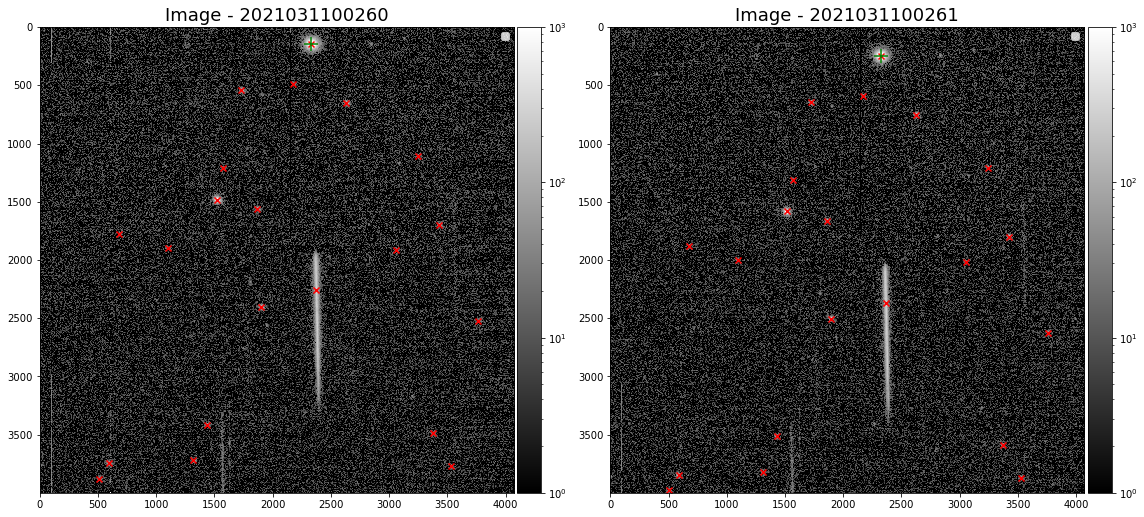

In [18]:
# Plot the images
plt.figure(figsize=(16,8))
plotCounter = 1
for expId in [expId1, expId2]:
    charVisit = charVisits[f"{expId}"]
    plt.subplot(1,2,plotCounter)
    plotCounter += 1
    plt.title(f"Image - {expId}",fontsize=18)
    arr = charVisit['exp'].image.array
    arr = np.clip(arr, 1, 100000) # This image has some negative values, and this removes them
    img = plt.imshow(arr, norm=LogNorm(vmin=1, vmax=1000),  interpolation='Nearest', cmap='gray')
    cat = charVisit['brightCatalog']
    plt.scatter(cat['base_SdssCentroid_x'],cat['base_SdssCentroid_y']\
                ,color='red', marker='x')
    plt.scatter([charVisit['brightestCentroid'][0]],[charVisit['brightestCentroid'][1]] \
                ,color='green', marker='+', s=200)
    colorbar(img)
    plt.legend()
    #plt.ylim(0,4000)
plt.tight_layout(h_pad=1)
#plt.savefig(f"/project/cslage/AuxTel/offsets/Offsets_{expIds[0]}_{expIds[1]}_{expIds[2]}_{expIds[3]}_16Apr21.pdf")